In [2]:
import numpy as np
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.util import add_cyclic_point
import copy
import xarray as xr

In [4]:
ds = xr.open_dataset("/glade/scratch/jinmuluo/archive/fanv3only_clmnox_huang2015/lnd/hist/fanv3_debugging.clm2.h0.2001-05.nc")
ds

<xarray.Dataset>
Dimensions:                        (levgrnd: 25, levsoi: 20, levlak: 10,
                                    levdcmp: 25, time: 1, hist_interval: 2,
                                    lon: 144, lat: 96, cft: 64, glc_nec: 10,
                                    ltype: 9, natpft: 15, nvegwcs: 4)
Coordinates:
  * levgrnd                        (levgrnd) float32 0.01 0.04 ... 28.87 42.0
  * levsoi                         (levsoi) float32 0.01 0.04 0.09 ... 6.94 8.03
  * levlak                         (levlak) float32 0.05 0.6 2.1 ... 34.33 44.78
  * levdcmp                        (levdcmp) float32 0.01 0.04 ... 28.87 42.0
  * time                           (time) datetime64[ns] 2001-06-01
  * lon                            (lon) float32 0.0 2.5 5.0 ... 355.0 357.5
  * lat                            (lat) float32 -90.0 -88.11 ... 88.11 90.0
Dimensions without coordinates: hist_interval, cft, glc_nec, ltype, natpft,
                                nvegwcs
Data variables: (12/552)
    mcdate                         (time) int32 ...
    mcsec                          (time) int32 ...
    mdcur                          (time) int32 ...
    mscur                          (time) int32 ...
    nstep                          (time) int32 ...
    time_bounds                    (time, hist_interval) datetime64[ns] ...
    ...                             ...
    XSMRPOOL                       (time, lat, lon) float32 ...
    XSMRPOOL_RECOVER               (time, lat, lon) float32 ...
    ZBOT                           (time, lat, lon) float32 ...
    ZWT                            (time, lat, lon) float32 ...
    ZWT_CH4_UNSAT                  (time, lat, lon) float32 ...
    ZWT_PERCH                      (time, lat, lon) float32 ...
Attributes: (12/101)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 03/27/23 21:51:47
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    cft_irrigated_tropical_corn:          62
    cft_tropical_soybean:                 63
    cft_irrigated_tropical_soybean:       64
    time_period_freq:                     month_1
    Time_constant_3Dvars_filename:        ./fanv3_debugging.clm2.h0.2000-01.nc
    Time_constant_3Dvars:                 ZSOI:DZSOI:WATSAT:SUCSAT:BSW:HKSAT:...

In [5]:
def map_function(da, cb=0, cmap='viridis', panel=None,  ax=None, title=None, vmax=None, vmin=None, units=None,nbins=200):
    "a function to make one subplot"
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon)

    if ax is None: ax = plt.gca()

    # define the colormap, including the number of bins
    cmap = copy.copy(plt.get_cmap(cmap,nbins))
    im = ax.pcolormesh(wrap_lon,da.lat,wrap_data,transform=ccrs.PlateCarree(), vmax=vmax,vmin=vmin,cmap=cmap)

    # set the bounds of your plot
    ax.set_extent([-180,180,-90,90], crs=ccrs.PlateCarree())

    # add title & panel labels
    ax.set_title(title,loc='left', fontsize='large', fontweight='bold')
    ax.annotate(panel, xy=(0.05, 0.90), xycoords=ax.transAxes, ha='center', va='center',fontsize=16)    

    # add plotting features
    ax.coastlines()
    ocean = ax.add_feature(cfeature.NaturalEarthFeature('physical','ocean','110m', facecolor='white'))
    
    # control colorbars on each plot & their location
    if cb == 1:
        cbar = fig.colorbar(im, ax=ax,pad=0.02, fraction = 0.03, orientation='horizontal')
        cbar.set_label(units,size=12,fontweight='bold')
    if cb == 2:
        cbar = fig.colorbar(im, ax=ax,pad=0.02, fraction = 0.05, orientation='vertical')    
        cbar.set_label(units,size=12)#,weight='bold')
        

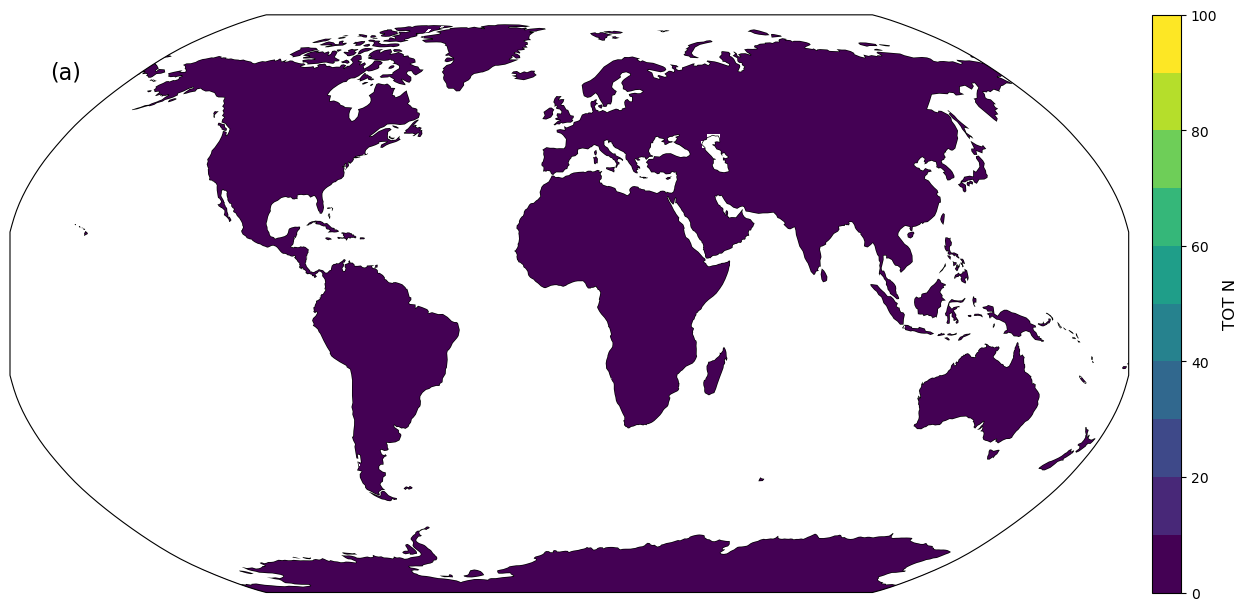

In [10]:
var="pftmask"
i = 0
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(13,6), constrained_layout=True, subplot_kw=dict(projection=ccrs.Robinson()))
for index, ax in np.ndenumerate(axes):
    if i == 0:
        #plotData = ds[var].isel(time=0)
        plotData = ds[var]
        map_function(plotData, ax=ax,cb=2, panel='(a)', nbins=10, vmax=100, vmin=0, units='TOT N')                  
    i = i+1
